In [8]:
import pm4py
import pandas
import numpy as np
import matplotlib.pyplot as plt
import os
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
import warnings
warnings.filterwarnings('ignore')

In [9]:
# Carga de datos y filtrado inicial de eventos
event_log = pandas.read_csv('Data/A1-presencial-log.csv')
event_log = event_log[~event_log['NombreEvento'].str.contains(r'C?R+')]

extra_data = pandas.read_csv("Data/A1-presencial-dataset.csv")
event_log_full = pandas.merge(left=event_log,
                    right=extra_data,
                    left_on='Idusuario',
                    right_on='Idusuario',
                    how="left")

event_log_full = pm4py.format_dataframe(event_log_full, case_id='Idusuario', activity_key='NombreEvento', timestamp_key='Hora')
print(len(event_log_full.Idusuario.unique()))
# Se eliminan los 2 alumnos que no tienen datos en el dataset, pero si acciones en el log
event_log_full = event_log_full[event_log_full['GRUPO'].notna()]
print(len(event_log_full.Idusuario.unique()))

106
104


In [10]:
# Se anaden 2 columnas nuevas para simplificar los calculos: nota media de ambos cuestionarios y numero total de eventos realizados en el anyo.
event_log_full['MEDIA_DILEMAS'] = (event_log_full['DILEMA1'] + event_log_full['DILEMA2'])/2
event_log_full['TOTAL_EVENTOS'] = event_log_full['#2015-06'] + event_log_full['#2015-07'] + event_log_full['#2015-08'] + event_log_full['#2015-09'] + event_log_full['#2015-10'] + event_log_full['#2015-11'] + event_log_full['#2015-12'] + event_log_full['#2016-01'] + event_log_full['#2016-02'] + event_log_full['#2016-03'] + event_log_full['#2016-04'] + event_log_full['#2016-05']

# valores de los parametros utilizados: noise_threshold, dependency_threshold, loop_two_threshold
nt = 0.2
d = 0.8
l = 0.7

In [11]:
# Media del numero de eventos realizados en total
print(event_log_full['TOTAL_EVENTOS'].mean())

287.32391008174386


In [12]:
### Modelos segun el horario: manyana
event_log_M = event_log_full.loc[(event_log_full['HORARIO']=='M')]

process_tree_M = pm4py.discover_process_tree_inductive(event_log_M, noise_threshold=nt)
bpmn_model_M = pm4py.convert_to_bpmn(process_tree_M)
pm4py.save_vis_bpmn(bpmn_model_M, 'Graphs/Horario/Models/M-Modelo.png')
map_M = pm4py.discover_heuristics_net(event_log_M, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_M, 'Graphs/Horario/Heuristics/M-Heuristic.png')

net, im, fm = pm4py.discover_petri_net_inductive(event_log_M, noise_threshold=nt)
pm4py.save_vis_petri_net(net, im, fm, 'Graphs/Horario/Petris/M-Petri.png')

### Modelos segun el horario: tarde
event_log_T = event_log_full.loc[(event_log_full['HORARIO']=='T')]

process_tree_T = pm4py.discover_process_tree_inductive(event_log_T, noise_threshold=nt)
bpmn_model_T = pm4py.convert_to_bpmn(process_tree_T)
pm4py.save_vis_bpmn(bpmn_model_T, 'Graphs/Horario/Models/T-Modelo.png')
map_T = pm4py.discover_heuristics_net(event_log_T, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_T, 'Graphs/Horario/Heuristics/T-Heuristic.png')

net, im, fm = pm4py.discover_petri_net_inductive(event_log_T, noise_threshold=nt)
pm4py.save_vis_petri_net(net, im, fm, 'Graphs/Horario/Petris/T-Petri.png')

In [13]:
### Modelos segun el grupo de estudio (A, B, C, D)
grupos = event_log_full.GRUPO.unique()
# bucle para los modelos de cada grupo
for gr in grupos:
    event_log_g = event_log_full.loc[(event_log_full['GRUPO']==gr)]

    # Red heuristica
    map_0 = pm4py.discover_heuristics_net(event_log_g, dependency_threshold=d, loop_two_threshold=l)
    model_name = "Graphs/Grupos/Heuristics/{}-Heuristic.png".format(gr)
    pm4py.save_vis_heuristics_net(map_0, model_name)
    # Modelo BPMN
    process_tree = pm4py.discover_process_tree_inductive(event_log_g, noise_threshold=nt)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    model_name = "Graphs/Grupos/Models/{}-Modelo.png".format(gr)
    pm4py.save_vis_bpmn(bpmn_model, model_name)
    # Red Petri
    net, im, fm = pm4py.discover_petri_net_inductive(event_log_g, noise_threshold=nt)
    petri_name = "Graphs/Grupos/Petri/{}-Petri.png".format(gr)
    pm4py.save_vis_petri_net(net, im, fm, petri_name)

In [14]:
### Modelos según la media de los cuestionarios: suspensos (<1), aprobados bajos y aprobados altos
mark_lim = np.round(np.arange(1, 2, 0.1), 1).tolist()

# Se separan los aprobados primero
event_log_pass = event_log_full.loc[(event_log_full['MEDIA_DILEMAS']>=1)]

for m in mark_lim:
    # Conjunto aprobados altos
    event_log_h = event_log_pass.loc[(event_log_pass['MEDIA_DILEMAS']>m)]
    # Conjunto aprobados bajos
    event_log_l = event_log_pass.loc[(event_log_pass['MEDIA_DILEMAS']<=m)]

    # Heuristico aprobados altos
    map_0 = pm4py.discover_heuristics_net(event_log_h, dependency_threshold=d, loop_two_threshold=l)
    model_name = "Graphs/Grades-3p/Heuristics/{}-PassH-Heuristic.png".format(m)
    pm4py.save_vis_heuristics_net(map_0, model_name)
    # Heuristico aprobados bajos
    map_0 = pm4py.discover_heuristics_net(event_log_l, dependency_threshold=d, loop_two_threshold=l)
    model_name = "Graphs/Grades-3p/Heuristics/{}-PassL-Heuristic.png".format(m)
    pm4py.save_vis_heuristics_net(map_0, model_name)

    # Modelo BPMN aprobados altos
    process_tree = pm4py.discover_process_tree_inductive(event_log_h, noise_threshold=nt)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    model_name = "Graphs/Grades-3p/Models/{}-PassH-Modelo.png".format(m)
    pm4py.save_vis_bpmn(bpmn_model, model_name)
    # Red Petri aprobados altos
    net, im, fm = pm4py.discover_petri_net_inductive(event_log_h, noise_threshold=nt)
    petri_name = "Graphs/Grades-3p/Petris/{}-PassH-Petri.png".format(m)
    pm4py.save_vis_petri_net(net, im, fm, petri_name)

    # Modelo BPMN aprobados bajos
    process_tree = pm4py.discover_process_tree_inductive(event_log_l, noise_threshold=nt)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    model_name = "Graphs/Grades-3p/Models/{}-PassL-Modelo.png".format(m)
    pm4py.save_vis_bpmn(bpmn_model, model_name)
    # Red Petri aprobados bajos
    net, im, fm = pm4py.discover_petri_net_inductive(event_log_l, noise_threshold=nt)
    petri_name = "Graphs/Grades-3p/Petris/{}-PassL-Petri.png".format(m)
    pm4py.save_vis_petri_net(net, im, fm, petri_name)

# Modelos de los suspensos
event_log_fail = event_log_full.loc[(event_log_full['MEDIA_DILEMAS']<1)]
# Heuristico
map_0 = pm4py.discover_heuristics_net(event_log_fail, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_0, "Graphs/Grades-3p/Heuristics/Fail-Heuristic.png")
# Modelo BPMN
process_tree = pm4py.discover_process_tree_inductive(event_log_fail, noise_threshold=nt)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.save_vis_bpmn(bpmn_model, 'Graphs/Grades-3p/Models/Fail-Modelo.png')
# Red Petri
net, im, fm = pm4py.discover_petri_net_inductive(event_log_fail, noise_threshold=nt)
pm4py.save_vis_petri_net(net, im, fm, 'Graphs/Grades-3p/Petris/Fail-Petri.png')

In [15]:
### Alumnos no presentados a ningun cuestionario
event_log_NP = event_log_full.loc[(event_log_full['DILEMA1'].isna()) & (event_log_full['DILEMA2'].isna())]
# Heuristico
map_0 = pm4py.discover_heuristics_net(event_log_NP, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_0, "Graphs/Grades-3p/Heuristics/NP-Heuristic.png")
# Modelo BPMN
process_tree = pm4py.discover_process_tree_inductive(event_log_NP, noise_threshold=nt)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
pm4py.save_vis_bpmn(bpmn_model, 'Graphs/Grades-3p/Models/NP-Modelo.png')
# Red Petri
net, im, fm = pm4py.discover_petri_net_inductive(event_log_NP, noise_threshold=nt)
pm4py.save_vis_petri_net(net, im, fm, 'Graphs/Grades-3p/Petris/NP-Petri.png')

In [16]:
### Modelos segun los resultados binarios: suspensos ambos cuestionarios, aprobados ambos o mitad y mitad.
# Aprobados los dos cuestionarios:
event_log_pass = event_log_full.loc[(event_log_full['DILEMA1C']=='Pass') & (event_log_full['DILEMA2C']=='Pass')]
# Aprobado solo uno:
event_log_mid = event_log_full.loc[((event_log_full['DILEMA1C']=='Pass') & (event_log_full['DILEMA2C']!='Pass')) | ((event_log_full['DILEMA1C']!='Pass') & (event_log_full['DILEMA2C']=='Pass'))]
# Suspensos ambos:
event_log_fail = event_log_full.loc[(event_log_full['DILEMA1C']!='Pass') & (event_log_full['DILEMA2C']!='Pass')]

# Heuristico pass
map_0 = pm4py.discover_heuristics_net(event_log_pass, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_0, "Graphs/Grades-Binary/Heuristics/Pass-Heuristic.png")
# Modelo BPMN pass
process_tree = pm4py.discover_process_tree_inductive(event_log_pass, noise_threshold=nt)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
model_name = "Graphs/Grades-Binary/Models/Pass-Modelo.png"
pm4py.save_vis_bpmn(bpmn_model, model_name)
# Red Petri pass
net, im, fm = pm4py.discover_petri_net_inductive(event_log_pass, noise_threshold=nt)
petri_name = "Graphs/Grades-Binary/Petris/Pass-Petri.png"
pm4py.save_vis_petri_net(net, im, fm, petri_name)

# Heuristico middle
map_0 = pm4py.discover_heuristics_net(event_log_mid, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_0, "Graphs/Grades-Binary/Heuristics/Mid-Heuristic.png")
# Modelo BPMN middle
process_tree = pm4py.discover_process_tree_inductive(event_log_mid, noise_threshold=nt)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
model_name = "Graphs/Grades-Binary/Models/Mid-Modelo.png"
pm4py.save_vis_bpmn(bpmn_model, model_name)
# Red Petri middle
net, im, fm = pm4py.discover_petri_net_inductive(event_log_mid, noise_threshold=nt)
petri_name = "Graphs/Grades-Binary/Mid-Petri.png"
pm4py.save_vis_petri_net(net, im, fm, petri_name)

# Heuristico fail
map_0 = pm4py.discover_heuristics_net(event_log_fail, dependency_threshold=d, loop_two_threshold=l)
pm4py.save_vis_heuristics_net(map_0, "Graphs/Grades-Binary/Heuristics/Fail-Heuristic.png")
# Modelo BPMN fail
process_tree = pm4py.discover_process_tree_inductive(event_log_fail, noise_threshold=nt)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
model_name = "Graphs/Grades-Binary/Models/Fail-Modelo.png"
pm4py.save_vis_bpmn(bpmn_model, model_name)
# Red Petri fail
net, im, fm = pm4py.discover_petri_net_inductive(event_log_fail, noise_threshold=nt)
petri_name = "Graphs/Grades-Binary/Fail-Petri.png"
pm4py.save_vis_petri_net(net, im, fm, petri_name)

In [18]:
### Modelos sobre el total de eventos realizados en el anyo.
### Puesto que el minimo ha sido 27, se suman 3 para redondear e ir de 10 en 10.
events_lim = np.arange(event_log_full['TOTAL_EVENTOS'].min()+3, event_log_full['TOTAL_EVENTOS'].max(), 10).tolist()

for e in events_lim:
    # Conjunto con mas eventos que el umbral
    event_log_h = event_log_full.loc[(event_log_full['TOTAL_EVENTOS']>e)]
    # Conjunto con menos eventos que el umbral
    event_log_l = event_log_full.loc[(event_log_full['TOTAL_EVENTOS']<=e)]

    # Puesto que son una gran cantidad de rutas y carpetas, se comprueba si existe y, en caso negativo, se crea la carpeta correspondiente.
    directory = "Graphs/Eventos/Heuristics/{}".format(e)
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory_model = "Graphs/Eventos/Models/{}".format(e)
    if not os.path.exists(directory_model):
        os.makedirs(directory_model)

    # directory_model = "Graphs/Eventos/Petri/{}".format(e)
    # if not os.path.exists(directory):
    #     os.makedirs(directory)

    # Heuristico gran cantidad de eventos
    map_0 = pm4py.discover_heuristics_net(event_log_h, dependency_threshold=d, loop_two_threshold=l)
    model_name = "{}/H-Events-Heuristic.png".format(directory)
    pm4py.save_vis_heuristics_net(map_0, model_name)
    # Modelo BPMN gran cantidad de eventos
    process_tree = pm4py.discover_process_tree_inductive(event_log_h, noise_threshold=nt)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    model_name = "{}/H-Events-Modelo.png".format(directory_model)
    pm4py.save_vis_bpmn(bpmn_model, model_name)
    ## Petri gran cantidad de eventos
    # net, im, fm = pm4py.discover_petri_net_inductive(event_log_h, noise_threshold=nt)
    # petri_name = "{}/H-Events-Petri.png".format(directory)
    # pm4py.save_vis_petri_net(net, im, fm, petri_name)

    # Heuristico baja cantidad de eventos
    map_0 = pm4py.discover_heuristics_net(event_log_l, dependency_threshold=d, loop_two_threshold=l)
    model_name = "{}/L-Events-Heuristic.png".format(directory)
    pm4py.save_vis_heuristics_net(map_0, model_name)
    # Modelo BPMN baja cantidad de eventos
    process_tree = pm4py.discover_process_tree_inductive(event_log_l, noise_threshold=nt)
    bpmn_model = pm4py.convert_to_bpmn(process_tree)
    model_name = "{}/L-Events-Modelo.png".format(directory_model)
    pm4py.save_vis_bpmn(bpmn_model, model_name)
    ## Petri baja cantidad de eventos
    # net, im, fm = pm4py.discover_petri_net_inductive(event_log_l, noise_threshold=nt)
    # petri_name = "{}/L-Events-Petri.png".format(directory)
    # pm4py.save_vis_petri_net(net, im, fm, petri_name)

In [19]:
## Heuristic params heatmap - el parametro and_threshold no afecta, por lo que no se incluye.
## Ademas, umbrales bajo 0.5 tampoco mejoran nada.
values = np.arange(0, 5, 1).tolist() # para poder guardar los valores en matrices y dibujarlas directamente
# inicializacion de matrices para conformance checking
fitness_avg_trace_m = np.zeros((len(values), len(values)))
prec_m = np.zeros((len(values), len(values)))
gen_m = np.zeros((len(values), len(values)))
simplicity_m = np.zeros((len(values), len(values)))

for d in values:
    val_d = 0.5 + d/10 # los valores de los umbrales no coinciden con los de las matrices
    for l in values:
        val_l = 0.5 + l/10
        # Red Petri
        netb, imb, fmb = pm4py.discover_petri_net_heuristics(event_log_full, dependency_threshold=val_d, loop_two_threshold=val_l)

        dFitness = pm4py.fitness_token_based_replay(event_log_full, netb, imb, fmb)
        fitness_avg_trace_m[4-d][l] = dFitness['average_trace_fitness']
        prec_value = pm4py.precision_token_based_replay(event_log_full, netb, imb, fmb)
        prec_m[4-d][l] = prec_value
        gen_m[4-d][l] = generalization_evaluator.apply(event_log_full, netb, imb, fmb)
        simplicity_m[4-d][l] = simplicity_evaluator.apply(netb)

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/2531 [00:00<?, ?it/s]

replaying log with TBR, completed variants ::   0%|          | 0/90 [00:00<?, ?it/s]

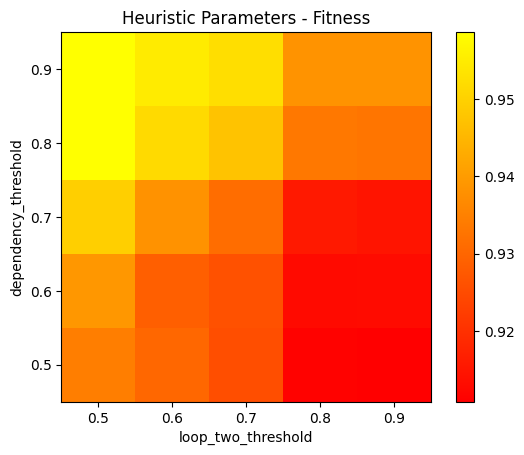

In [20]:
# Fitness
im = plt.imshow(fitness_avg_trace_m, cmap='autumn')
plt.colorbar(im)
plt.title("Heuristic Parameters - Fitness")
val_t = [(v/10+0.5) for v in values]
plt.xticks(list(range(len(val_t))), val_t)
plt.yticks(list(range(len(val_t)-1, -1, -1)), val_t)
plt.xlabel('loop_two_threshold')
plt.ylabel('dependency_threshold')
plt.show()

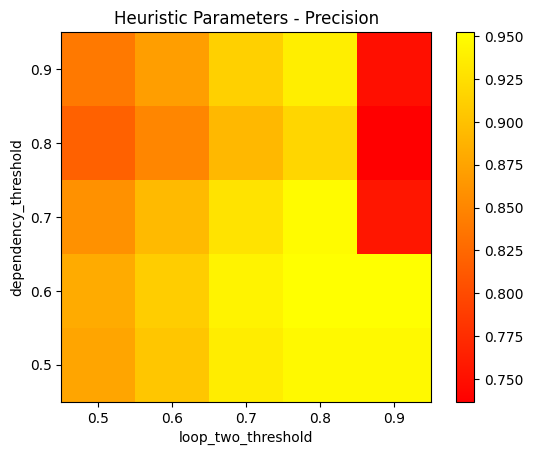

In [21]:
# Precision
im = plt.imshow(prec_m, cmap='autumn')
plt.colorbar(im)
plt.title("Heuristic Parameters - Precision")
plt.xticks(list(range(len(val_t))), val_t)
plt.yticks(list(range(len(val_t)-1, -1, -1)), val_t)
plt.xlabel('loop_two_threshold')
plt.ylabel('dependency_threshold')
plt.show()

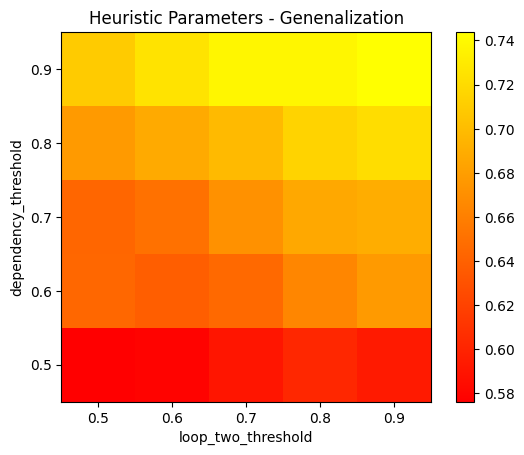

In [22]:
# Genenalization
im = plt.imshow(gen_m, cmap='autumn')
plt.colorbar(im)
plt.title("Heuristic Parameters - Genenalization")
plt.xticks(list(range(len(val_t))), val_t)
plt.yticks(list(range(len(val_t)-1, -1, -1)), val_t)
plt.xlabel('loop_two_threshold')
plt.ylabel('dependency_threshold')
plt.show()

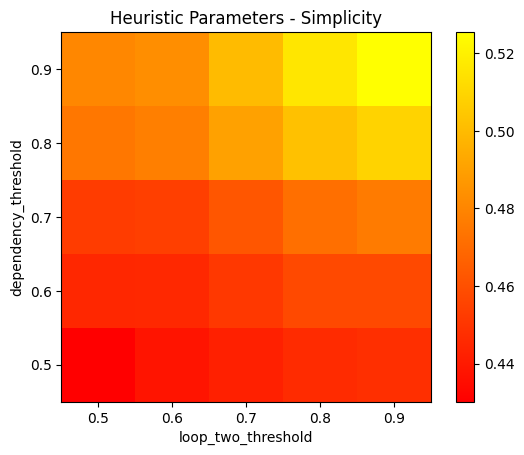

In [23]:
# Simplicity
im = plt.imshow(simplicity_m, cmap='autumn')
plt.colorbar(im)
plt.title("Heuristic Parameters - Simplicity")
plt.xticks(list(range(len(val_t))), val_t)
plt.yticks(list(range(len(val_t)-1, -1, -1)), val_t)
plt.xlabel('loop_two_threshold')
plt.ylabel('dependency_threshold')
plt.show()